In [1]:
import pandas as pd
from Parser import parse_sugar_se

result = parse_sugar_se() 
free = result.free_energy
dse  = result.dispersive_surface_energy
inj  = result.injection_items

In [12]:
inj.columns

Index(['ID', 'Injection Name', 'Solvent', 'Injection Time [ms]',
       'Duration [min]', 'Target Fractional Surface Coverage',
       'Actual Fractional Surface Coverage', 'Column Temperature [Kelvin]',
       'Column Pressure Drop [Torr]', 'Exit Flow Rate [sccm]',
       'Peak Area [µV•min]', 'Peak Max (Signal) [µV]', 'Peak Max (Time) [min]',
       'Peak Com [min]', 'Peak Com/Max', 'Ret Volume (Max) [ml/g]',
       'Ret Volume (Com) [ml/g]', 'Net Ret Time (Max) [min]',
       'Sp. Ret Volume (Max) [ml/g]', 'Net Ret Time (Com) [min]',
       'Sp. Ret Volume (Com) [ml/g]', 'Partial Pressure [Torr]',
       'Pres Ret Volume (Max) [mMol/(g•Torr)]',
       'Pres Ret Volume (Com) [mMol/(g•Torr)]', 'Injected Amount  [mMol/g]',
       'Injected Amount  [mMol]', 'Adsorbed Amount (Max) [mMol/g]',
       'Adsorbed Amount  (Com) [mMol/g]'],
      dtype='object')

In [21]:
g_plot = inj.loc[inj["Solvent"].ne("Methane"), [
    'Solvent', 'Target Fractional Surface Coverage', 'Actual Fractional Surface Coverage', 'Sp. Ret Volume (Com) [ml/g]',
]]
g_plot = g_plot.sort_values("Target Fractional Surface Coverage").reset_index(drop=True)
g_plot.head(10)

,Solvent,Target Fractional Surface Coverage,Actual Fractional Surface Coverage,Sp. Ret Volume (Com) [ml/g]
0,DECANE,0.005,0.005062,53.610867
1,NONANE,0.005,0.005232,17.223618
2,HEPTANE,0.005,0.006175,1.698860
3,OCTANE,0.005,0.005822,5.284075
4,ACETONITRILE,0.005,0.007542,4.712945
5,ETHYL ACETATE,0.005,0.007967,7.697347
6,ETHANOL,0.005,0.007811,18.142229
7,HEXANE,0.009,0.013050,0.478555
8,ETHYL ACETATE,0.010,0.013068,6.811959
9,HEXANE,0.010,0.013163,0.476473


### I realised that the experimental data is not idealistic and does not have actual surface coverages in the coverages we want to analyse. I needed to have an extrapolation to get to these ideal n/nm values.

In [33]:
import numpy as np
import pandas as pd

# Coverages you want on the final plots (x-locations to evaluate at)
target_grid = np.array([0.005, 0.01, 0.025, 0.05, 0.10, 0.14], dtype=float)

g2 = g_plot.copy()

# Ensure numeric
g2["Target Fractional Surface Coverage"] = pd.to_numeric(g2["Target Fractional Surface Coverage"], errors="coerce")
g2["Actual Fractional Surface Coverage"] = pd.to_numeric(g2["Actual Fractional Surface Coverage"], errors="coerce")
g2["Sp. Ret Volume (Com) [ml/g]"] = pd.to_numeric(g2["Sp. Ret Volume (Com) [ml/g]"], errors="coerce")

# Keep rows that can be used for interpolation
g2 = g2.dropna(subset=["Solvent", "Actual Fractional Surface Coverage", "Sp. Ret Volume (Com) [ml/g]"]).copy()

# --- build a temperature lookup from inj: (Solvent, Actual coverage) -> Temperature ---
temp_lookup = (
    inj.loc[inj["Solvent"].ne("Methane"), ["Solvent", "Actual Fractional Surface Coverage", "Column Temperature [Kelvin]"]]
    .assign(
        **{
            "Actual Fractional Surface Coverage": pd.to_numeric(
                inj["Actual Fractional Surface Coverage"], errors="coerce"
            ),
            "Column Temperature [Kelvin]": pd.to_numeric(
                inj["Column Temperature [Kelvin]"], errors="coerce"
            ),
        }
    )
    .dropna(subset=["Solvent", "Actual Fractional Surface Coverage", "Column Temperature [Kelvin]"])
    # If duplicates exist at same solvent+coverage, average them
    .groupby(["Solvent", "Actual Fractional Surface Coverage"], as_index=False)["Column Temperature [Kelvin]"]
    .mean()
)

def _interp_vs_actual_with_closest_actual(df: pd.DataFrame) -> pd.DataFrame:
    """
    For each solvent:
      - Interpolate/extrapolate Sp. Ret Volume vs ACTUAL coverage onto target_grid.
      - Also report the ACTUAL coverage point that is "closest" to each target.
      - Pull Column Temperature [Kelvin] from inj at those closest-actual coverages.

    "Closest actual" rule:
      - If target is below the minimum actual: choose the minimum actual (lowest obtained).
      - If target is above the maximum actual: choose the maximum actual (highest obtained).
      - If target is inside the range: choose the nearest actual by absolute difference.
        (Ties are broken toward the smaller actual.)
    """
    sol = df["Solvent"].iloc[0]
    df = df.sort_values("Actual Fractional Surface Coverage").copy()

    x = df["Actual Fractional Surface Coverage"].to_numpy(float)
    y = df["Sp. Ret Volume (Com) [ml/g]"].to_numpy(float)

    m = np.isfinite(x) & np.isfinite(y)
    xk, yk = x[m], y[m]

    out = pd.DataFrame({"Solvent": sol, "Target Fractional Surface Coverage": target_grid})

    if len(xk) < 2:
        out["Closest Actual Fractional Surface Coverage"] = np.nan
        out["Closest Sp. Ret Volume (Com) [ml/g]"] = np.nan
        out["Sp. Ret Volume (Com) [ml/g] (interp)"] = np.nan
        out["Closest Column Temperature [Kelvin]"] = np.nan
        return out

    # --- Interpolation (and extrapolation using end slopes) ---
    y_interp = np.interp(target_grid, xk, yk)

    # Linear extrapolation on the left
    left = target_grid < xk.min()
    if left.any():
        x0, x1 = xk[0], xk[1]
        y0, y1 = yk[0], yk[1]
        slope = (y1 - y0) / (x1 - x0)
        y_interp[left] = y0 + slope * (target_grid[left] - x0)

    # Linear extrapolation on the right
    right = target_grid > xk.max()
    if right.any():
        x0, x1 = xk[-2], xk[-1]
        y0, y1 = yk[-2], yk[-1]
        slope = (y1 - y0) / (x1 - x0)
        y_interp[right] = y1 + slope * (target_grid[right] - x1)

    out["Sp. Ret Volume (Com) [ml/g] (interp)"] = y_interp

    # --- Closest-actual reporting (and temperature lookup) ---
    closest_actual = np.empty_like(target_grid, dtype=float)
    closest_spret = np.empty_like(target_grid, dtype=float)

    xmin, xmax = float(xk.min()), float(xk.max())

    for i, t in enumerate(target_grid):
        if t <= xmin:
            j = 0  # lowest actual obtained
        elif t >= xmax:
            j = len(xk) - 1  # highest actual obtained
        else:
            diffs = np.abs(xk - t)
            j_candidates = np.where(diffs == diffs.min())[0]
            j = int(j_candidates[0])  # tie -> smaller actual (xk is sorted)

        closest_actual[i] = xk[j]
        closest_spret[i] = yk[j]

    out["Closest Actual Fractional Surface Coverage"] = closest_actual
    out["Closest Sp. Ret Volume (Com) [ml/g]"] = closest_spret

    # Pull temperature at the chosen closest-actual coverages for this solvent
    # We do a small merge-like lookup per solvent here for simplicity/clarity.
    tmp = pd.DataFrame(
        {
            "Solvent": sol,
            "Closest Actual Fractional Surface Coverage": closest_actual,
        }
    ).merge(
        temp_lookup,
        left_on=["Solvent", "Closest Actual Fractional Surface Coverage"],
        right_on=["Solvent", "Actual Fractional Surface Coverage"],
        how="left",
    )

    out["Closest Column Temperature [Kelvin]"] = tmp["Column Temperature [Kelvin]"].to_numpy()

    return out

combined = g2.groupby("Solvent", group_keys=False).apply(_interp_vs_actual_with_closest_actual)
combined = combined.sort_values(["Target Fractional Surface Coverage", "Solvent"]).reset_index(drop=True)

combined

/var/folders/g2/8zyjglrn4c7dqmvyh0hq9p4m0000gn/T/ipykernel_62421/235826595.py:128: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined = g2.groupby("Solvent", group_keys=False).apply(_interp_vs_actual_with_closest_actual)


,Solvent,Target Fractional Surface Coverage,Sp. Ret Volume (Com) [ml/g] (interp),Closest Actual Fractional Surface Coverage,Closest Sp. Ret Volume (Com) [ml/g],Closest Column Temperature [Kelvin]
0,ACETONE,0.005,3.170181,0.015957,2.683052,303.148119
1,ACETONITRILE,0.005,5.175680,0.007542,4.712945,303.149580
2,DECANE,0.005,53.669112,0.005062,53.610867,303.149080
3,DICHLOROMETHANE,0.005,0.439833,0.014905,0.424418,303.149775
4,ETHANOL,0.005,19.745971,0.007811,18.142229,303.148290
5,ETHYL ACETATE,0.005,8.212280,0.007967,7.697347,303.154365
6,HEPTANE,0.005,1.716903,0.006175,1.698860,303.149715
7,HEXANE,0.005,0.627129,0.013050,0.478555,303.148410
8,NONANE,0.005,17.300992,0.005232,17.223618,303.153345
9,OCTANE,0.005,5.334291,0.005822,5.284075,303.150485


In [29]:
carbon_number = {
    "HEXANE": 6,
    "HEPTANE": 7,
    "OCTANE": 8,
    "NONANE": 9,
    "DECANE": 10,
    "UNDECANE": 11,
    "DODECANE": 12,
}

In [34]:
alkane = combined[combined["Solvent"].map(carbon_number).notna()].copy()
alkane["Carbon Number"] = alkane["Solvent"].map(carbon_number)
alkane

,Solvent,Target Fractional Surface Coverage,Sp. Ret Volume (Com) [ml/g] (interp),Closest Actual Fractional Surface Coverage,Closest Sp. Ret Volume (Com) [ml/g],Closest Column Temperature [Kelvin],Carbon Number
2,DECANE,0.005,53.669112,0.005062,53.610867,303.149080,10
6,HEPTANE,0.005,1.716903,0.006175,1.698860,303.149715,7
7,HEXANE,0.005,0.627129,0.013050,0.478555,303.148410,6
8,NONANE,0.005,17.300992,0.005232,17.223618,303.153345,9
9,OCTANE,0.005,5.334291,0.005822,5.284075,303.150485,8
12,DECANE,0.010,49.099008,0.009799,49.144812,303.144260,10
16,HEPTANE,0.010,1.630277,0.009623,1.645906,303.152150,7
17,HEXANE,0.010,0.534852,0.013050,0.478555,303.148410,6
18,NONANE,0.010,15.653550,0.009838,15.689417,303.151705,9
19,OCTANE,0.010,5.028231,0.009960,5.031211,303.145825,8


In [42]:
V = alkane["Sp. Ret Volume (Com) [ml/g] (interp)"].to_numpy(float)
T = alkane["Closest Column Temperature [Kelvin]"].to_numpy(float)

def RTlnV(V, T, R=8.31446261815324):
    """Vectorized: compute RT*ln(V) for arrays/Series. Returns an array."""
    V = np.asarray(V, dtype=float)
    T = np.asarray(T, dtype=float)
    return np.where(V > 0, R * T * np.log(V), np.nan)

alkane["RTlnVg"] = RTlnV(
    alkane["Sp. Ret Volume (Com) [ml/g] (interp)"],
    alkane["Closest Column Temperature [Kelvin]"],
)
alkane

,Solvent,Target Fractional Surface Coverage,Sp. Ret Volume (Com) [ml/g] (interp),Closest Actual Fractional Surface Coverage,Closest Sp. Ret Volume (Com) [ml/g],Closest Column Temperature [Kelvin],Carbon Number,RTlnVg,RTlog10Vg
2,DECANE,0.005,53.669112,0.005062,53.610867,303.149080,10,10038.828652,4359.807888
6,HEPTANE,0.005,1.716903,0.006175,1.698860,303.149715,7,1362.400713,591.683112
7,HEXANE,0.005,0.627129,0.013050,0.478555,303.148410,6,-1176.081851,-510.765858
8,NONANE,0.005,17.300992,0.005232,17.223618,303.153345,9,7185.513127,3120.628701
9,OCTANE,0.005,5.334291,0.005822,5.284075,303.150485,8,4219.765977,1832.621079
12,DECANE,0.010,49.099008,0.009799,49.144812,303.144260,10,9814.349210,4262.317705
16,HEPTANE,0.010,1.630277,0.009623,1.645906,303.152150,7,1231.918036,535.015205
17,HEXANE,0.010,0.534852,0.013050,0.478555,303.148410,6,-1577.252949,-684.992252
18,NONANE,0.010,15.653550,0.009838,15.689417,303.151705,9,6933.253356,3011.073674
19,OCTANE,0.010,5.028231,0.009960,5.031211,303.145825,8,4070.770561,1767.913192


### This is were i realised I used the wrong Retention Volume and thought i would get copilot to clean this mess up

In [45]:
import numpy as np
import pandas as pd

# -----------------------------
# 1) SETTINGS
# -----------------------------
target_grid = np.array([0.005, 0.01, 0.025, 0.05, 0.10, 0.14], dtype=float)

carbon_number = {
    "HEXANE": 6, "HEPTANE": 7, "OCTANE": 8, "NONANE": 9,
    "DECANE": 10, "UNDECANE": 11, "DODECANE": 12,
}

R = 8.31446261815324  # J/(mol*K)

# -----------------------------
# 2) PICK YOUR FREE TABLE DF
#    (rename this line to match your notebook variable)
# -----------------------------
free_df = free  # <-- change if your free-energy table df is named differently

# -----------------------------
# 3) PREP FREE TABLE: keep only what we need
# -----------------------------
free_v = free_df[["Solvent Name", "n/nm", "Interpolated Retention Volume (Com)"]].copy()
free_v = free_v.rename(columns={
    "Solvent Name": "Solvent",
    "n/nm": "Coverage",
})

free_v["Coverage"] = pd.to_numeric(free_v["Coverage"], errors="coerce")
free_v["Interpolated Retention Volume (Com)"] = pd.to_numeric(
    free_v["Interpolated Retention Volume (Com)"], errors="coerce"
)
free_v = free_v.dropna(subset=["Solvent", "Coverage", "Interpolated Retention Volume (Com)"])

# -----------------------------
# 4) INTERPOLATE/EXTRAPOLATE V ONTO target_grid (PER SOLVENT)
# -----------------------------
def interp_V_on_grid(df_sol: pd.DataFrame) -> pd.DataFrame:
    sol = df_sol["Solvent"].iloc[0]
    df_sol = df_sol.sort_values("Coverage").copy()

    x = df_sol["Coverage"].to_numpy(float)
    y = df_sol["Interpolated Retention Volume (Com)"].to_numpy(float)

    m = np.isfinite(x) & np.isfinite(y)
    xk, yk = x[m], y[m]

    out = pd.DataFrame({
        "Solvent": sol,
        "Target Fractional Surface Coverage": target_grid,
    })

    if len(xk) < 2:
        out["Interpolated Retention Volume (Com) (extrap)"] = np.nan
        return out

    # linear interpolation (np.interp clamps outside range)
    y_out = np.interp(target_grid, xk, yk)

    # linear extrapolation on left (instead of clamping)
    left = target_grid < xk.min()
    if left.any():
        x0, x1 = xk[0], xk[1]
        y0, y1 = yk[0], yk[1]
        slope = (y1 - y0) / (x1 - x0)
        y_out[left] = y0 + slope * (target_grid[left] - x0)

    # linear extrapolation on right
    right = target_grid > xk.max()
    if right.any():
        x0, x1 = xk[-2], xk[-1]
        y0, y1 = yk[-2], yk[-1]
        slope = (y1 - y0) / (x1 - x0)
        y_out[right] = y1 + slope * (target_grid[right] - x1)

    out["Interpolated Retention Volume (Com) (extrap)"] = y_out
    return out

combined = free_v.groupby("Solvent", group_keys=False).apply(interp_V_on_grid)

# -----------------------------
# 5) TEMPERATURE FROM inj (closest actual coverage)
# -----------------------------
inj_t = inj.loc[inj["Solvent"].ne("Methane"), ["Solvent", "Actual Fractional Surface Coverage", "Column Temperature [Kelvin]"]].copy()
inj_t["Actual Fractional Surface Coverage"] = pd.to_numeric(inj_t["Actual Fractional Surface Coverage"], errors="coerce")
inj_t["Column Temperature [Kelvin]"] = pd.to_numeric(inj_t["Column Temperature [Kelvin]"], errors="coerce")
inj_t = inj_t.dropna(subset=["Solvent", "Actual Fractional Surface Coverage", "Column Temperature [Kelvin]"])

def add_closest_temp(df_solvent: pd.DataFrame) -> pd.DataFrame:
    sol = df_solvent["Solvent"].iloc[0]
    temp_pts = inj_t[inj_t["Solvent"].eq(sol)].copy()
    if temp_pts.empty:
        df_solvent["Closest Actual Fractional Surface Coverage"] = np.nan
        df_solvent["Closest Column Temperature [Kelvin]"] = np.nan
        return df_solvent

    x = temp_pts["Actual Fractional Surface Coverage"].to_numpy(float)
    tvals = temp_pts["Column Temperature [Kelvin]"].to_numpy(float)

    targets = df_solvent["Target Fractional Surface Coverage"].to_numpy(float)
    closest_x = np.array([x[np.argmin(np.abs(x - tt))] for tt in targets], dtype=float)

    temp_map = temp_pts.groupby("Actual Fractional Surface Coverage")["Column Temperature [Kelvin]"].mean()
    closest_T = np.array([temp_map.get(cx, np.nan) for cx in closest_x], dtype=float)

    df_solvent["Closest Actual Fractional Surface Coverage"] = closest_x
    df_solvent["Closest Column Temperature [Kelvin]"] = closest_T
    return df_solvent

combined = combined.groupby("Solvent", group_keys=False).apply(add_closest_temp)

# -----------------------------
# 6) FILTER TO ALKANES + COMPUTE RT ln(V)
# -----------------------------
alkane = combined.assign(**{"Carbon Number": combined["Solvent"].map(carbon_number)}).dropna(subset=["Carbon Number"]).copy()
alkane["Carbon Number"] = alkane["Carbon Number"].astype(int)

V = alkane["Interpolated Retention Volume (Com) (extrap)"].to_numpy(float)
T = alkane["Closest Column Temperature [Kelvin]"].to_numpy(float)

alkane["RTlnVg"] = np.where((V > 0) & np.isfinite(T), R * T * np.log(V), np.nan)

alkane = alkane.sort_values(["Target Fractional Surface Coverage", "Carbon Number"]).reset_index(drop=True)

alkane.head(12)

/var/folders/g2/8zyjglrn4c7dqmvyh0hq9p4m0000gn/T/ipykernel_62421/1854114601.py:81: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined = free_v.groupby("Solvent", group_keys=False).apply(interp_V_on_grid)
/var/folders/g2/8zyjglrn4c7dqmvyh0hq9p4m0000gn/T/ipykernel_62421/1854114601.py:112: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined = combined.groupby("Solvent", group_keys=False).apply(add_closest_temp)


,Solvent,Target Fractional Surface Coverage,Interpolated Retention Volume (Com) (extrap),Closest Actual Fractional Surface Coverage,Closest Column Temperature [Kelvin],Carbon Number,RTlnVg
0,HEPTANE,0.005,1.716903,0.006175,303.149715,7,1362.400709
1,OCTANE,0.005,5.334291,0.005822,303.150485,8,4219.765993
2,NONANE,0.005,17.300992,0.005232,303.153345,9,7185.513124
3,DECANE,0.005,53.669112,0.005062,303.149080,10,10038.828662
4,HEPTANE,0.010,1.630277,0.009623,303.152150,7,1231.918054
5,OCTANE,0.010,5.028230,0.009960,303.145825,8,4070.770546
6,NONANE,0.010,15.653374,0.009838,303.151705,9,6933.224983
7,DECANE,0.010,49.099008,0.009799,303.144260,10,9814.349208
8,HEPTANE,0.025,1.512409,0.020079,303.149020,7,1042.749157
9,OCTANE,0.025,4.485320,0.022277,303.149195,8,3782.825115


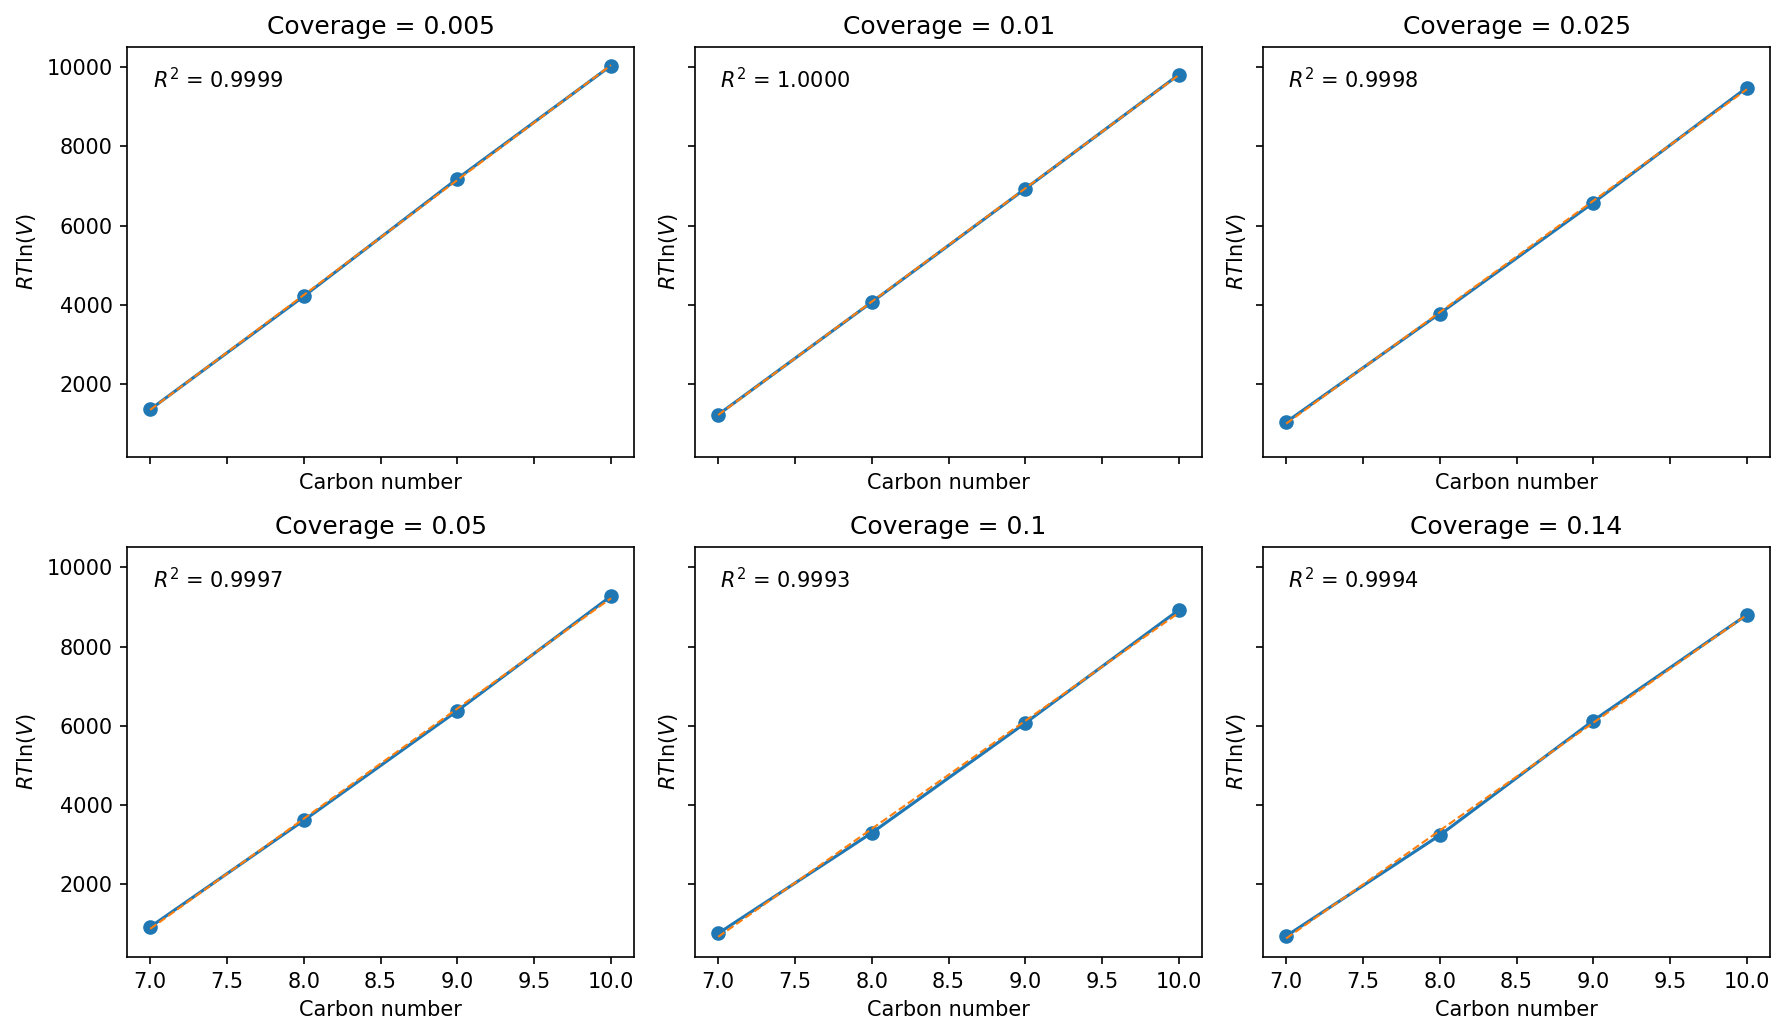

In [46]:
import matplotlib.pyplot as plt

coverages = target_grid  # the 6 you want

fig, axes = plt.subplots(2, 3, figsize=(12, 7), dpi=150, sharex=True, sharey=True)
axes = axes.ravel()

for ax, cov in zip(axes, coverages):
    sub = alkane.loc[alkane["Target Fractional Surface Coverage"].eq(cov)].copy()
    sub = sub.dropna(subset=["Carbon Number", "RTlnVg"]).sort_values("Carbon Number")

    x = sub["Carbon Number"].to_numpy(float)
    y = sub["RTlnVg"].to_numpy(float)

    # scatter/line through points
    ax.plot(x, y, "o-", linewidth=1.5)

    # linear fit + R^2 (only if enough points)
    if len(x) >= 2:
        m, b = np.polyfit(x, y, 1)          # y = m x + b
        yhat = m * x + b
        ss_res = np.sum((y - yhat) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        r2 = np.nan if ss_tot == 0 else 1 - ss_res / ss_tot

        # plot best-fit line
        ax.plot(x, yhat, "--", linewidth=1)

        # annotate R^2
        ax.text(
            0.05, 0.95,
            f"$R^2$ = {r2:.4f}",
            transform=ax.transAxes,
            va="top",
            ha="left",
        )

    ax.set_title(f"Coverage = {cov:g}")
    ax.set_xlabel("Carbon number")
    ax.set_ylabel(r"$RT\ln(V)$")

# If there are extra axes (not in your case), hide them
for ax in axes[len(coverages):]:
    ax.axis("off")

plt.tight_layout()
plt.show()